In [195]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import re

import numpy as np
from numba import njit, prange
from scipy.ndimage import rotate
from scipy.spatial.transform import Rotation as rot

import astropy.units as u
import astropy.constants as c
import astropy.io.fits as fits
from astropy.visualization import quantity_support

quantity_support()

%matplotlib widget

figsize=(12,7)

In [196]:
@njit(parallel=True)
def circ_mask(image_w, image_h, N_side, center, radius):
    x_res = image_w / N_side
    y_res = image_h / N_side
    src = np.ones((N_side, N_side))
    for i in prange(N_side):
        for j in prange(N_side):
            if np.sqrt((i * x_res - center[0])**2 + (j * y_res - center[1])**2) > radius:
                src[i][j] = 0
    return src

## Parse Zemax output files

In [197]:
src_surf_name = 'p2'
# irradiance and phase data from POP to a surface are output as arrays in a plane,
# propagating with some orientation wrt a reference surface.
# this plane has x,y axes aligned perpendicular to the chief ray.
direc = '/home/evanmayer/TIME_data/mirror_mapping/zemax/pop_system/TIME_data/'
amp_file = src_surf_name + '_launch_irr.txt'
phase_file = src_surf_name + '_launch_phase.txt'
src_amp = np.genfromtxt(direc + amp_file, skip_header=15, encoding='utf-16')
src_phase = np.genfromtxt(direc + phase_file, skip_header=15, encoding='utf-16')
src = src_amp * np.cos(src_phase) + 1j * src_amp * np.sin(src_phase)

### Input source parameters

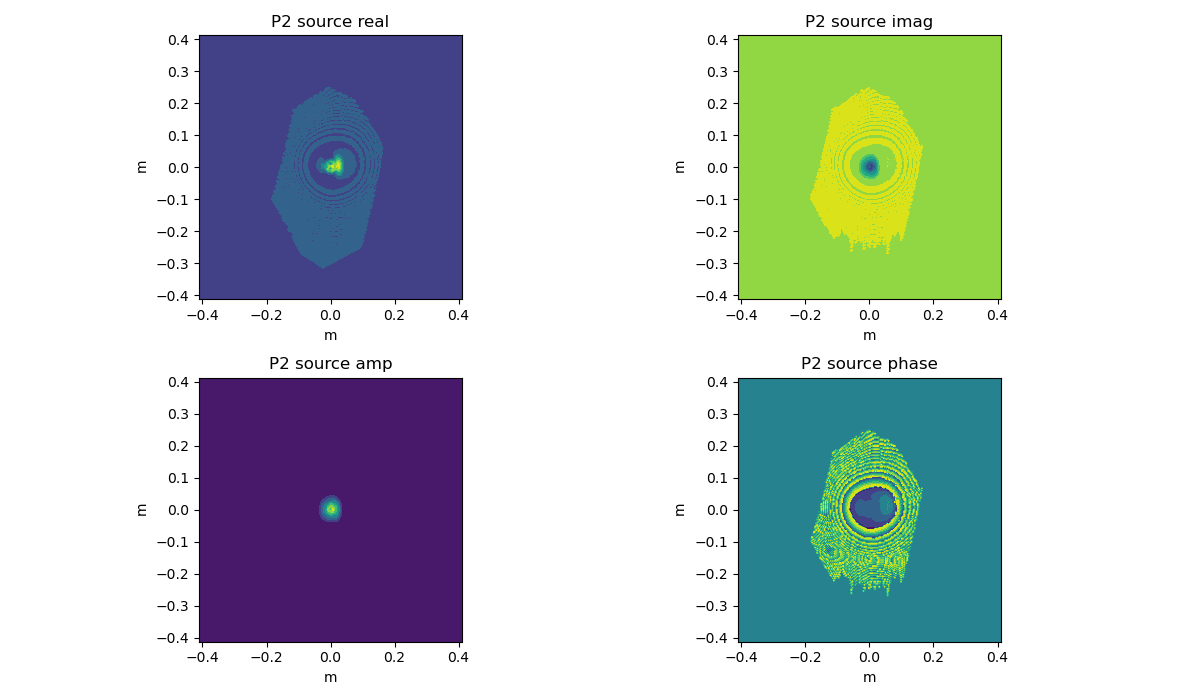

In [198]:
# the propagation report tells us how the POP data array orientation changes from start to finish.
# TODO: parse from beam file
src_m_per_px = (3.2 * u.mm).to(u.m)
lambd = (922. * u.micron).to(u.m)
src_width = (824 * u.mm).to(u.m)
src_height = src_width
assert(src.shape[0] == src.shape[1]), "Non-square input data!"
N = src.shape[0]

# src = circ_mask(src_width, src_height, N, (src_width / 2., src_height / 2.), src_width / 16.)

xs = np.linspace(-src_width / 2, src_width / 2, N)
ys = np.linspace(-src_height / 2, src_height / 2, N)
xx, yy = np.meshgrid(xs, ys)
zz = np.zeros_like(xx)

fig, ax = plt.subplots(figsize=figsize, nrows=2, ncols=2)
ax[0,0].contourf(xx, yy, (src.real))
ax[0,0].set_aspect('equal')
ax[0,0].set_title(f'{src_surf_name.upper()} source real')
ax[0,1].contourf(xx, yy, (src.imag))
ax[0,1].set_aspect('equal')
ax[0,1].set_title(f'{src_surf_name.upper()} source imag')

ax[1,0].contourf(xx, yy, np.abs(src))
ax[1,0].set_aspect('equal')
ax[1,0].set_title(f'{src_surf_name.upper()} source amp')
ax[1,1].contourf(xx, yy, np.angle(src))
ax[1,1].set_aspect('equal')
ax[1,1].set_title(f'{src_surf_name.upper()} source phase')
fig.tight_layout()

### Construct the location of each source point in the frame of the beamfile

In [199]:
src_coords = np.zeros((xx.shape[0] * xx.shape[1], 3))
for i in range(src_coords.shape[0]):
    src_coords[i][0] = xx.flatten()[i].value
    src_coords[i][1] = yy.flatten()[i].value
    src_coords[i][2] = zz.flatten()[i].value

### Load in sag data

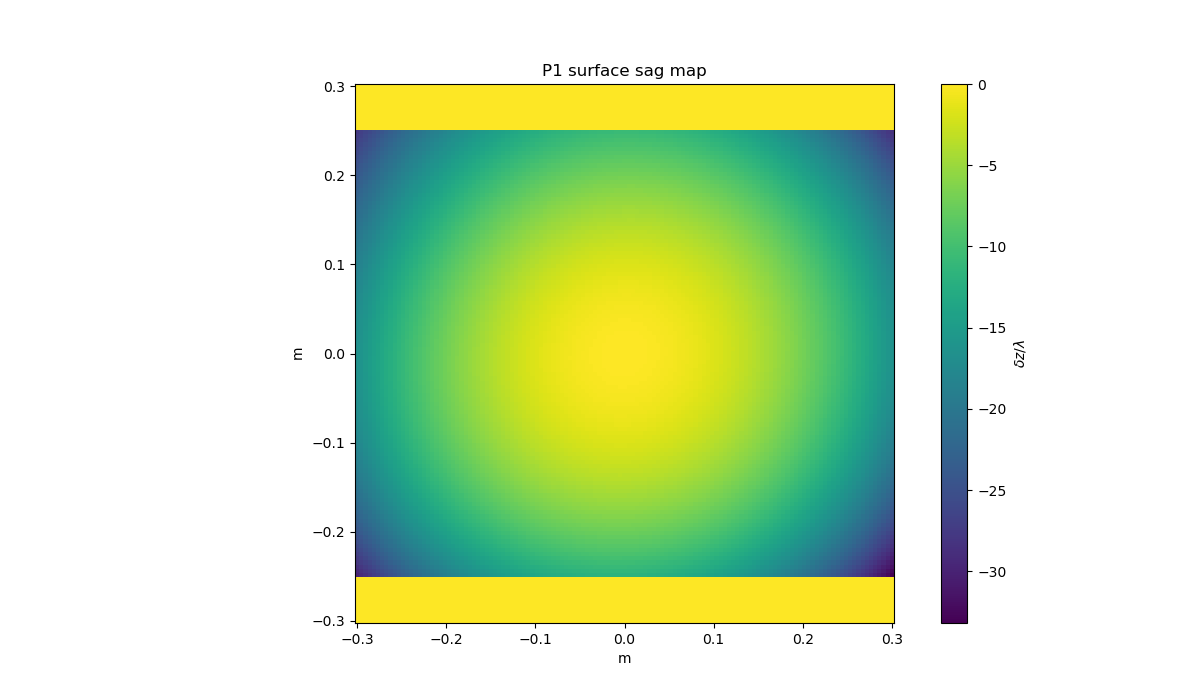

In [200]:
dest_surf_name = 'p1'
sag_file = dest_surf_name + '_sag.txt'
# dz = np.zeros((129, 129)) * u.m
dz = (np.genfromtxt(direc + sag_file, skip_header=15, encoding='utf-16') * u.mm).to(u.m)
assert(dz.shape[0] == dz.shape[1]), "Non-square sag data!"
dz_min = dz.min()
dz_max = dz.max()

# fiducial: (0,0) dimple in dz
dz[0][0] += 0.05 * u.m

N_img = dz.shape[0]

# TODO: parse from file
sag_width = (600. * u.mm).to(u.m)
sag_height = sag_width
sag_m_per_px = (4.6875 * u.mm).to(u.m)

xs_img = np.linspace(-sag_width / 2, sag_width / 2, N_img)
ys_img = np.linspace(-sag_height / 2, sag_height / 2, N_img)
xx_img, yy_img = np.meshgrid(xs_img, ys_img)

fig, ax = plt.subplots(figsize=figsize)
im = ax.pcolormesh(xx_img, yy_img, (dz / lambd).decompose(), vmin=dz_min / lambd, vmax=dz_max / lambd)
ax.set_title(f'{dest_surf_name.upper()} surface sag map')
ax.set_aspect('equal')
fig.colorbar(im, ax=ax, label='$\delta z / \lambda$')

### Construct the location of each field point in the frame of the mirror

In [201]:
dest_coords = np.zeros((dz.shape[0] * dz.shape[1], 3))
for i in range(dest_coords.shape[0]):
    dest_coords[i][0] = xx_img.flatten()[i].value
    dest_coords[i][1] = yy_img.flatten()[i].value
    dest_coords[i][2] = dz.flatten()[i].value

### Parse propagation report

In order to get rotation matrices of beam axes relative to surface local axes.

In [202]:
beamfile_matrices = {}
surf_query = 'Surface transfer from before'
surf_num = 0
mat = []
togo = -1
with open(direc + src_surf_name + '_launch_prop_report.txt', encoding='utf-16') as f:
    for line in f.readlines():
        if line.startswith(surf_query):
            s = line.lstrip(surf_query)
            slist = s.split()
            surf_num = int(slist[-1])
        if line.startswith('Orientation matrix'):
            mat = []
            togo = 4
        if togo < 4 and togo > 0:
            mat.append([float(s) for s in line.lstrip().split()])
        elif togo == 0:
            if surf_num not in beamfile_matrices.keys():
                beamfile_matrices[surf_num] = [np.array(mat)] # "Before" matrix
            else:
                beamfile_matrices[surf_num].append(np.array(mat)) # "After" matrix
        togo -= 1

### Parse system prescription file report

In order to get rotation matrices of surface local axes relative to global frame.

In [203]:
global_matrices = {}
global_section_start_query = 'GLOBAL VERTEX COORDINATES, ORIENTATIONS, AND ROTATION/OFFSET MATRICES:'
global_section_end_query = 'GLOBAL SURFACE CENTER OF CURVATURE POINTS:'
global_section_skiplines = 7
surf_num = 0
mat = []
togo = -1
with open(direc + 'system_prescription.txt', encoding='utf-16') as f:
    # Skip all lines until we get to the global rotation matrix section.
    while global_section_start_query not in line:
        line = f.readline()
        continue
    # Skip until matrices start
    while global_section_skiplines:
        global_section_skiplines -= 1
        line = f.readline()
    # Read each matrix
    while global_section_end_query not in line:
        if not line.rstrip(): # skip empty lines between matrices
            line = f.readline()
            continue
        slist = line.split()
        if 5 < len(slist): # a line with a surface number, and maybe a label
            surf_num = int(slist[0])
            matline = slist[1:4]
            mat = []
            togo = 2
        else: # just matrix data
            matline = slist[:3]
        assert len(matline) == 3
        mat.append([float(val) for val in matline])
        if togo == 2:
            x = float(slist[4])
        elif togo == 1:
            y = float(slist[3])
        elif togo == 0: # save off matrix
            z = float(slist[3])
            global_matrices[surf_num] = [np.array(mat), (np.array([x,y,z]) * u.mm).to(u.m)]
        togo -= 1
        line = f.readline()

In [204]:
# mapping of surface number to name
important_keys = {
    0: 'Beam origin',
    11: 'Zotefoam',
    16: 'P2',
    24: 'P1',
    27: 'F1',
    31: 'K3',
    34: 'K2',
    37: 'K1',
    39: 'flange',
    40: 'cabin floor',
}

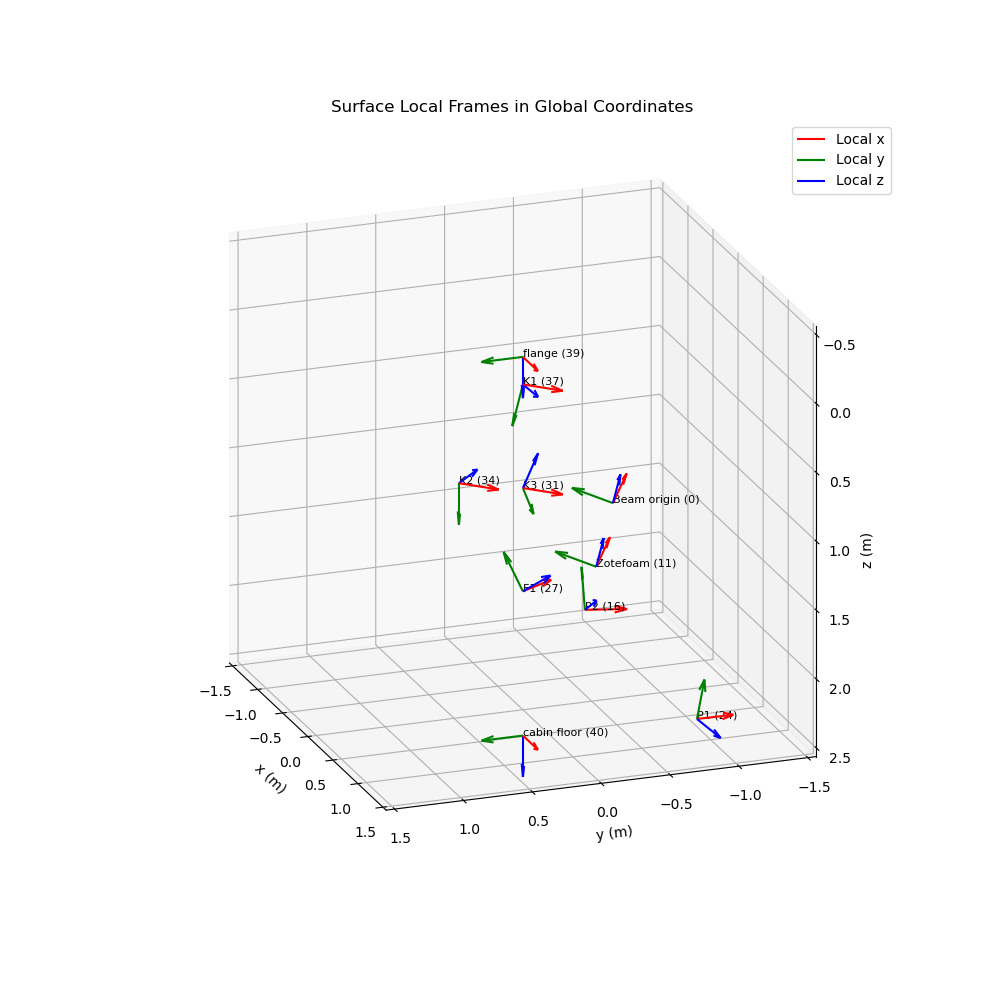

In [205]:
def plot_important_surfaces(global_matrices, important_keys):
    sz = .3
    first_time = True
    fig, ax = plt.subplots(figsize=(10,10), nrows=1, ncols=1, subplot_kw={'projection':'3d'})
    for key in global_matrices.keys():
        if key in important_keys.keys():
            if first_time: # don't spam legends
                leg_mod = ''
            else:
                leg_mod = '_'
            ax.quiver3D(
                global_matrices[key][1][0],
                global_matrices[key][1][1],
                global_matrices[key][1][2],
                sz * global_matrices[key][0][0,0],
                sz * global_matrices[key][0][1,0],
                sz * global_matrices[key][0][2,0],
                color='red',
                label=leg_mod + 'Local x'
            )
            ax.quiver3D(
                global_matrices[key][1][0],
                global_matrices[key][1][1],
                global_matrices[key][1][2],
                sz * global_matrices[key][0][0,1],
                sz * global_matrices[key][0][1,1],
                sz * global_matrices[key][0][2,1],
                color='green',
                label=leg_mod + 'Local y'
            )
            ax.quiver3D(
                global_matrices[key][1][0],
                global_matrices[key][1][1],
                global_matrices[key][1][2],
                sz * global_matrices[key][0][0,2],
                sz * global_matrices[key][0][1,2],
                sz * global_matrices[key][0][2,2],
                color='blue',
                label=leg_mod + 'Local z'
            )
            ax.text(
                global_matrices[key][1][0].value,
                global_matrices[key][1][1].value,
                global_matrices[key][1][2].value,
                important_keys[key] + f' ({key})',
                fontsize=8
            )
            if first_time:
                first_time = False
    ax.legend(loc='best')

    ax.set_proj_type('ortho')
    ax.set_title('Surface Local Frames in Global Coordinates')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_zlabel('z (m)')

    vbox_size = 3
    ax.set_xlim(-vbox_size / 2, vbox_size / 2)
    ax.set_ylim(-vbox_size / 2, vbox_size / 2)
    ax.set_zlim(np.array([-vbox_size / 2, vbox_size / 2]) + 1)
    ax.set_box_aspect([1,1,1])
    ax.view_init(azim=-160, elev=-160.)

    return fig, ax

fig, ax = plot_important_surfaces(global_matrices, important_keys)

### Transform destination points into global frame points

In [206]:
# dest: surface of p1
dest_surf = 24
# transform from surface local frame to global frame
R_global_to_local = rot.from_matrix(global_matrices[dest_surf][0].T)
R_local_to_global = R_global_to_local.inv()
# mirror surface coordinates in global frame
dest_prime = R_local_to_global.apply(dest_coords) * u.m + global_matrices[dest_surf][1]

### Transform source plane points into global frame points

In [207]:
# source: beam data from after p2
src_surf = 16

R_local_to_beam = rot.from_matrix(beamfile_matrices[src_surf][0]) # 1-index is beam matrix orientation after hitting src surface
R_beam_to_local = R_local_to_beam.inv()
# operator that transforms a vector from beam frame to global frame
R_beam_to_global = R_local_to_global * R_beam_to_local

src_prime = R_beam_to_global.apply(src_coords) * u.m + global_matrices[src_surf][1]

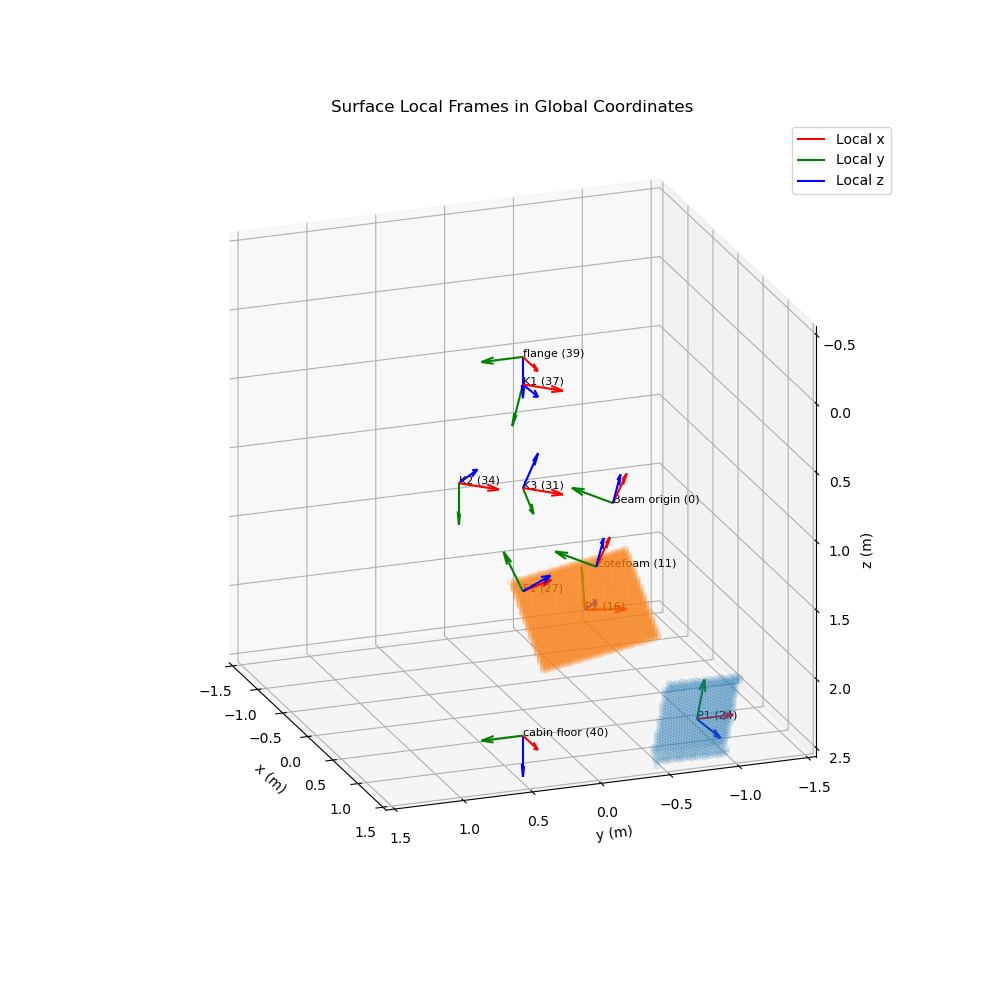

In [208]:
fig, ax = plot_important_surfaces(global_matrices, important_keys)

stride = 23
ax.scatter(dest_prime[::stride,0], dest_prime[::stride,1], dest_prime[::stride,2], alpha=0.1)
ax.scatter(src_prime[::stride,0], src_prime[::stride,1], src_prime[::stride,2], alpha=0.1)

## Calculate Fresnel Integral

In [209]:
@njit(parallel=True)
def E_fresnel(src, src_pts, pts, lambd):
    '''
    Calculate the Fresnel diffraction integral.
    
    The source field E(x',y',z') is stored in array src, the resulting diffracted field
    is calculated at each (x,y,z) point in array pts.

    Parameters
    ----------
    src : np.ndarray
        Source plane data
    src_pts : np.ndarray
        (N,3) array of x,y,z, points in the global frame on which lie the complex source data
    pts : np.ndarray
        (N,3) array of x,y,z, points in the global frame at which to calculate the diffraction integral
    lambd : float
        Operating wavelength, m

    Returns
    -------
    np.ndarray
        Fresnel diffraction pattern evaluated at pts
    '''
    A = 1. / (1j * lambd)
    k = 2. * np.pi / lambd
    e_fresnel = np.zeros(pts.shape[0], dtype=np.complex64)
    # for each point in the field
    for i in prange(len(pts)):
        x_dest, y_dest, z_dest = pts[i]
        # perform the fresnel integral over all source-field pairs
        res = np.zeros((src.shape[0], src.shape[1]), dtype=np.complex64)
        for ii in prange(src.shape[0]):
            for jj in prange(src.shape[1]):
                x_src = src_pts[jj+ii*src.shape[1]][0]
                y_src = src_pts[jj+ii*src.shape[1]][1]
                z_src = src_pts[jj+ii*src.shape[1]][2]
                r2 = (x_dest - x_src) ** 2. + (y_dest - y_src) ** 2. + (z_dest - z_src) ** 2.
                r = r2 ** .5
                res[ii][jj] = src[ii][jj] * np.exp(1j * k * r) * (z_dest - z_src) / r2
        # assumption: beam file pixels are square
        # side length = distance between adjacent points, d = sqrt((x'-x)^2 + (y'-y)^2 + (z'-z)^2)
        # area = (d)^2
        src_area_element = (
            (src_pts[1][0] - src_pts[0][0]) ** 2. +
            (src_pts[1][1] - src_pts[0][1]) ** 2. +
            (src_pts[1][2] - src_pts[0][2]) ** 2.
        )
        e_fresnel[i] = res.flatten().sum() * src_area_element # Riemann sum: \sum f(x,y) * dx * dy
    return A * e_fresnel

In [210]:
fresnel_img_list = E_fresnel(src, src_prime, dest_prime, lambd)
fresnel_img = fresnel_img_list.reshape(xx_img.shape)

In [211]:
intensity = np.abs(fresnel_img_list) ** 2.
mean_intens = np.mean(intensity[intensity != 0])
phase = np.angle(fresnel_img_list)
phase[intensity < mean_intens / 100.] = 0

src_prime_grid = src_prime.reshape((xx.shape[0], xx.shape[1], 3))
dest_prime_grid = dest_prime.reshape((xx_img.shape[0], xx_img.shape[1], 3))
intensity_grid = intensity.reshape((xx_img.shape[0], xx_img.shape[1]))
phase_grid = phase.reshape((xx_img.shape[0], xx_img.shape[1]))

### Plot results

/tmp/ipykernel_42130/1962754834.py:11: RuntimeWarning: divide by zero encountered in log10
  c=mask_nans(np.log10(src[::stride,::stride])),
/home/evanmayer/miniconda3/envs/astr/lib/python3.9/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


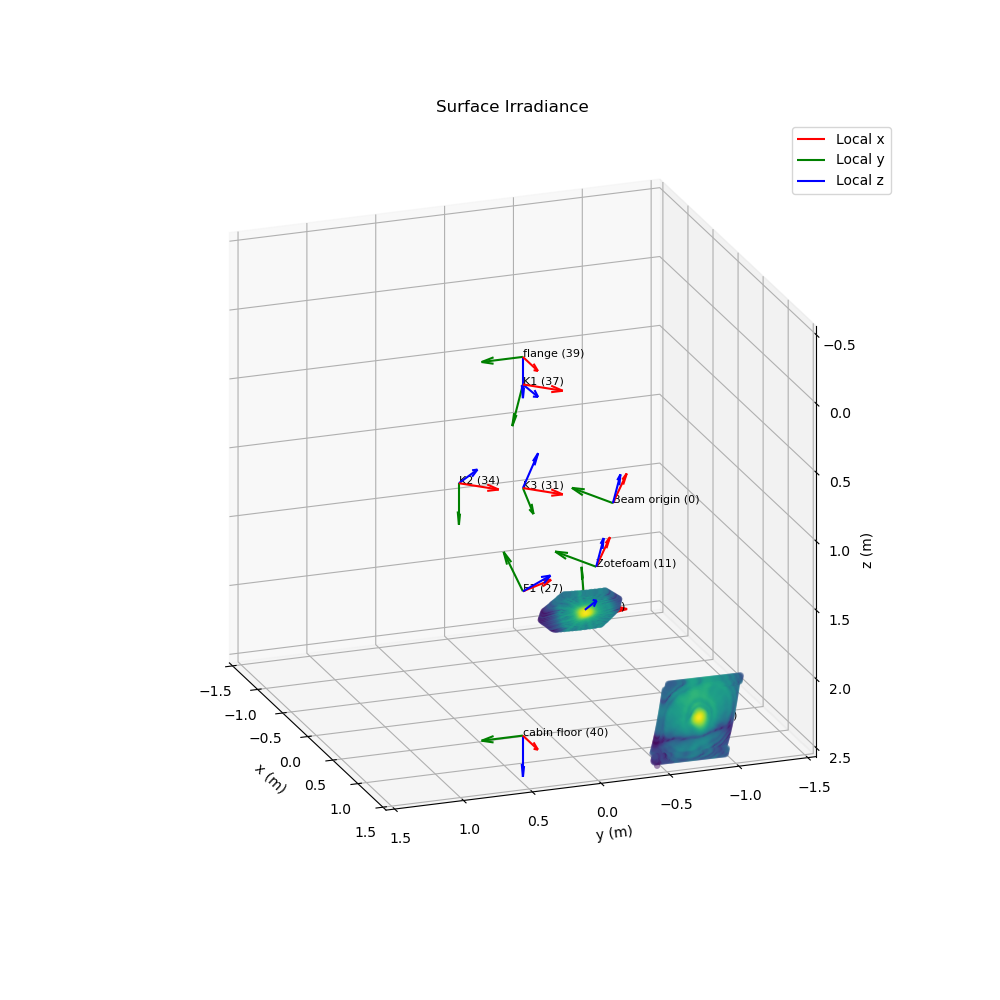

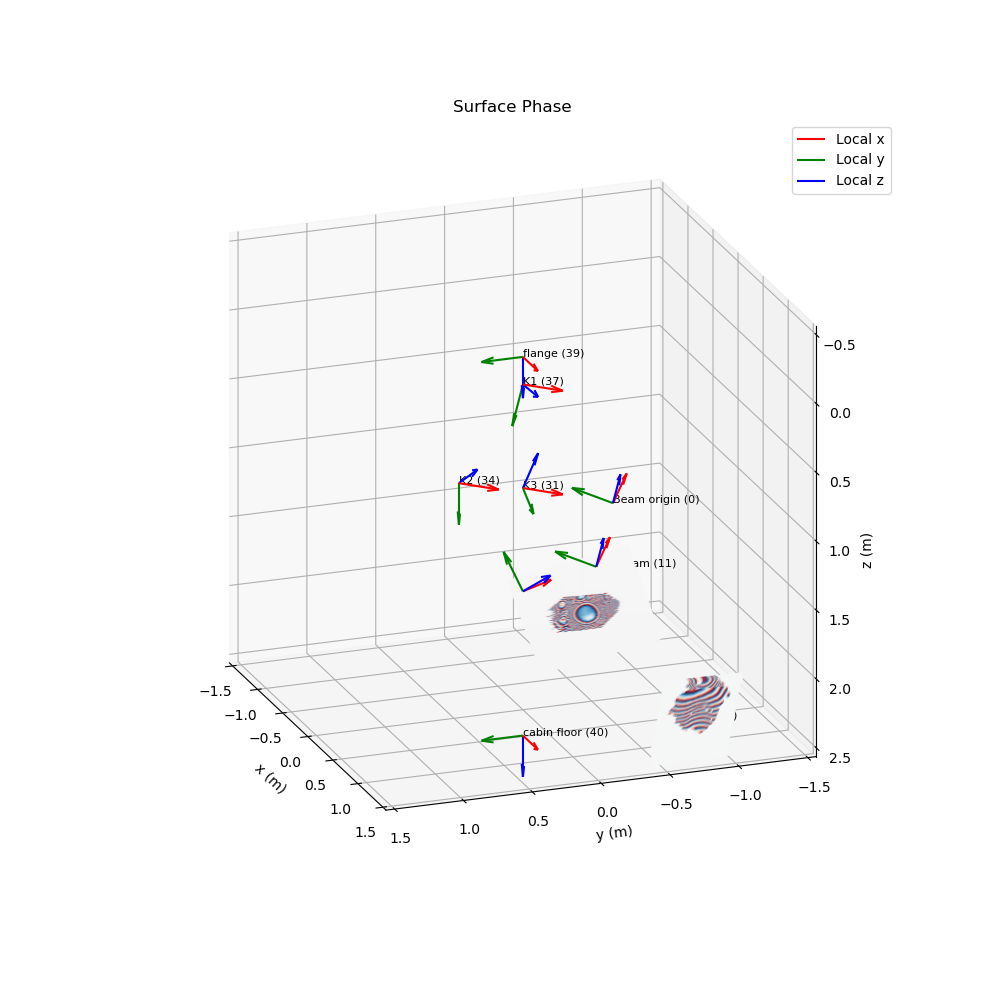

In [212]:
def mask_nans(arr):
    nan_mask = ~np.isnan(arr)
    return arr[nan_mask]

fig0, ax0 = plot_important_surfaces(global_matrices, important_keys)
stride = 2
ax0.scatter(
    src_prime_grid[::stride, ::stride, 0],
    src_prime_grid[::stride, ::stride, 1],
    src_prime_grid[::stride, ::stride, 2],
    c=mask_nans(np.log10(src[::stride,::stride])),
    edgecolor='none',
    alpha=0.5
)
ax0.scatter(
    dest_prime_grid[::stride, ::stride, 0],
    dest_prime_grid[::stride, ::stride, 1],
    dest_prime_grid[::stride, ::stride, 2],
    c=mask_nans(np.log10(intensity_grid[::stride,::stride])),
    edgecolor='none',
    alpha=0.5
)
ax0.set_title('Surface Irradiance')

fig0, ax1 = plot_important_surfaces(global_matrices, important_keys)
ax1.scatter(
    src_prime_grid[::stride, ::stride, 0],
    src_prime_grid[::stride, ::stride, 1],
    src_prime_grid[::stride, ::stride, 2],
    c=np.angle(src)[::stride,::stride],
    edgecolor='none',
    cmap='RdBu_r',
    alpha=0.5
)
ax1.scatter(
    dest_prime_grid[::stride, ::stride, 0],
    dest_prime_grid[::stride, ::stride, 1],
    dest_prime_grid[::stride, ::stride, 2],
    c=phase_grid[::stride,::stride],
    edgecolor='none',
    cmap='RdBu_r',
    alpha=0.5
)
ax1.set_title('Surface Phase')

all_pts = np.vstack([src_prime, dest_prime])
centroid = np.mean(all_pts, axis=0)
vbox_size = 3
# for ax in [ax0, ax1]:
    # ax.set_xlim(centroid[0] + np.array([-vbox_size / 2, vbox_size / 2]) * u.m)
    # ax.set_ylim(centroid[1] + np.array([-vbox_size / 2, vbox_size / 2]) * u.m)
    # ax.set_zlim(centroid[2] + np.array([-vbox_size / 2, vbox_size / 2]) * u.m)